In [46]:
import pandas as pd
import numpy as np
import zipfile
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense


In [47]:
url = 'https://archive.ics.uci.edu/static/public/508/qsar+oral+toxicity.zip'

# downloading
respuesta = requests.get(url)

# verificando descarga
if respuesta.status_code == 200:
    # abriendo el archivo .zip desde repuesta
    with zipfile.ZipFile(io.BytesIO(respuesta.content)) as archivo_zip:
        # listando archivos
        print("Archivos en el ZIP:", archivo_zip.namelist())

        # extrayendo archivo
        nombre_csv = archivo_zip.namelist()[0]  # first file
        with archivo_zip.open(nombre_csv) as archivo_csv:
            # Cargar el CSV en un DataFrame de pandas
            df = pd.read_csv(archivo_csv, sep= ';')
            print(df.head())  # primeras filas del dataframe
else:
    print("Download ERROR", respuesta.status_code)


Archivos en el ZIP: ['qsar_oral_toxicity.csv']
   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.962  0.963  0.964  \
0  0    0    1    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      1   
2  0    0    0    0    0    0    0    1    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  1    0    0    0    0    0    1    0    0    0  ...      0      0      0   

   0.965  0.966  0.967  0.968  0.969  0.970  negative  
0      0      0      0      0      0      0  negative  
1      0      0      0      0      0      0  negative  
2      0      0      0      0      0      0  negative  
3      0      0      0      0      0      0  negative  
4      0      0      1      0      0      0  negative  

[5 rows x 1025 columns]


In [48]:
# loading data
datos = df

# replace "positive" y "negative" for 1 and -1
datos['negative'] = datos['negative'].replace({'positive': 1, 'negative': -1})

# separating features and tags
X = datos.iloc[:, :-1].values  # all columns, except last
y = datos['negative'].values  # last column

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-48-fb58b476f92c>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos['negative'] = datos['negative'].replace({'positive': 1, 'negative': -1})


In [49]:
def reglas_if_then(x):
    # rules based in binaries features
    if x[0] == 1 and x[1] == 0:
        return 1
    elif x[0] == 0 and x[1] == 1:
        return -1
    else:
        return 0  # no definied clasification

# applying rules to training data for create initial tag volume
y_train_reglas = np.array([reglas_if_then(x) for x in X_train])


In [50]:
# create KBANN model using Keras
modelo = Sequential()
modelo.add(Dense(10, input_dim=X.shape[1], activation='relu'))  # hide layer : 10 neuron
modelo.add(Dense(1, activation='tanh'))  # out layer

# compiling model
modelo.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo con los datos preprocesados y las etiquetas definidas por las reglas si es necesario
modelo.fit(X_train, y_train_reglas, epochs=100, batch_size=10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8837 - loss: 0.1022
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9638 - loss: 0.0264
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9634 - loss: 0.0143
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9691 - loss: 0.0083
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9648 - loss: 0.0061
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9677 - loss: 0.0043
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9709 - loss: 0.0036
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9686 - loss: 0.0027
Epoch 9/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9645 - loss: 0.0037
Epoch 10/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9691 - loss: 0.0025
Epoch 11/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9700 - loss: 0.0027
Epoch 12/100
720/720 ━━━━━━━━━━━━━━━━━━━━

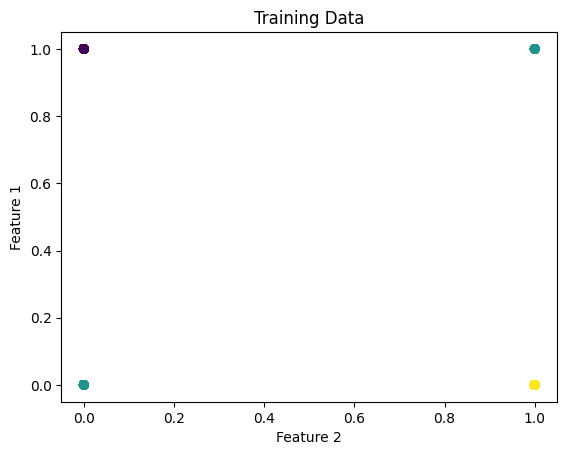

In [53]:
import matplotlib.pyplot as plt

def visualizar_datos(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('Feature 2')
    plt.ylabel('Feature 1')
    plt.title('Training Data')
    plt.show()

visualizar_datos(X_train, y_train_reglas)


In [52]:
def comprobar_aprendizaje(nuevos_datos):
    predicciones = modelo.predict(nuevos_datos)
    return np.where(predicciones > 0, 1, -1)  # Clasificar como positivo o negativo

# Ejemplo de nuevos datos para comprobar el aprendizaje del modelo
nuevos_datos = np.array([[1, 0], [0, 1]])  # Cambia esto a tus nuevos datos binarios
resultados = comprobar_aprendizaje(nuevos_datos)
print("Resultados de clasificación:", resultados)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 1024, but received input with shape (2, 2)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(2, 2), dtype=int64)
  • training=False
  • mask=None